In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

## extractGNSSAHD

This script opens the output from the DynaNet National Adjustment
and extracts those points which have AHD heights.

Only points which have an AHD height can be used in the development
of AUSGeoid.

NOTE: Not all the points coming out of the adjustment will have an AHD
height, this script is will extract only those points which have an
ellipsoidal height and an AHD height along with it's uncertainty
if it has been provided.

In [2]:
# import DynaNet file
ahd = pd.read_csv('ahd_gda2020_v1.3.dat',
                  delim_whitespace=True,
                  skiprows=1,
                  header=None,
                  names=['ID',
                         'CONST',
                         'LAT',
                         'LON',
                         'H_Ortho',
                         'h_Ellipse',
                         'X',
                         'Y',
                         'Z',
                         'SD_e',
                         'SD_n',
                         'SD_h',
                         'AHD',
                         'SD_AHD'])

In [3]:
ahd.head()

,ID,CONST,LAT,LON,H_Ortho,h_Ellipse,X,Y,Z,SD_e,SD_n,SD_h,AHD,SD_AHD
0,1000619,FFF,-20.316292,118.576728,5.0513,3.5189,-2.862249e+06,5.254814e+06,-2.200569e+06,0.0028,0.0025,0.0062,5.039,-999.0
1,1002227,FFF,-22.126620,114.082379,13.2778,-0.7578,-2.412071e+06,5.396704e+06,-2.387407e+06,0.0022,0.0019,0.0072,13.275,-999.0
2,100375,FFF,-30.857534,128.034238,169.3684,149.5934,-3.376551e+06,4.316469e+06,-3.252421e+06,0.0013,0.0013,0.0034,169.369,-999.0
3,100384,FFF,-28.179691,114.510054,271.8558,250.0941,-2.334196e+06,5.119546e+06,-2.994191e+06,0.0013,0.0012,0.0037,271.861,-999.0
4,100387,FFF,-31.578329,117.846459,329.0848,303.0600,-2.540553e+06,4.809131e+06,-3.320848e+06,0.0012,0.0012,0.0030,329.085,-999.0


In [4]:
print('No. pts in adjustment: ' + str(len(ahd)))
print('No. pts in adjustment with AHD ht included: '
      + str(len(ahd.loc[ahd.AHD != -999.000])))

No. pts in adjustment: 7642
No. pts in adjustment with AHD ht included: 7642


In [ ]:
ahd.to_csv(sep=' ')

In [28]:
ahd.iloc[0].Latitude

-20.316291533000001

Is the data type/precision for this correct?

/nix/store/7c6is2fjy2s4ad6j3rpixzbhm3ggmqcx-python3-3.6.4-env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/nix/store/7c6is2fjy2s4ad6j3rpixzbhm3ggmqcx-python3-3.6.4-env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


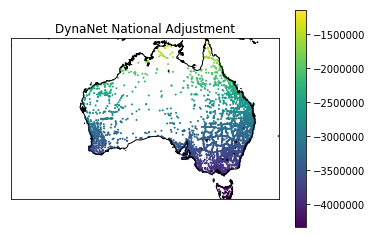

In [33]:
lats, lons = zip(*ahd[['LAT', 'LON']].values)
z = ahd['Z']

top = max(lats)
bottom = min(lats)
left = min(lons)
right = max(lons)
m = Basemap(projection='merc',
            resolution='l',
            lat_0=(top + bottom) / 2,
            lon_0=(left + right) / 2,
            area_thresh=0.1,
            llcrnrlon=left,
            llcrnrlat=bottom,
            urcrnrlon=right,
            urcrnrlat=top)

m.drawcoastlines()

lons, lats = m(lons, lats)

m.scatter(lons, lats, s=1, c=z)

plt.title("DynaNet National Adjustment")
plt.colorbar()

In [15]:
ahd['index2'] = pd.RangeIndex(start=1, stop=len(ahd)+1, step=1)

In [30]:
ahd.loc[ahd.AHD != -999.000][['index2',
                              'LAT',
                              'LON',
                              'h_Ellipse',
                              'SD_h',
                              'AHD',
                              'SD_AHD',
                              'ID']].to_csv('1_GNSSAHD.txt',
                                            sep=' ',
                                            header=False,
                                            index=False)

## estimateAHDsigma

This script opens the output from extractGNSSAHD and estimate the
AHD uncertainties at collocated GNSS + AHD sites which have no AHD
uncertainty.

### COMPUTE SIGMA

1. Read in a GNSS+AHD point
2. Check if it has a AHD uncertainty. If it does not, that is, it has an
   uncertainty value of -999, then compute an uncertainty based on distance
   to nearest JP. The program calculates the closest junction point to each
  GNSS+AHD pt and the uncertainty is 12 rt k where k is distance.
3. If it already has an uncertainty, write the GNSS+AHD points with a AHD uncertainty to file
4. SD_NAHD = sqrt((SD_h\*\*2)+(SD_GNSSAHD\*\*2))
   That is - the SD of Nahd does not include gravity model uncertainty